# Urban Analysis with Google Satellite Embeddings


This notebook demonstrates how to use UrbanPy to download and analyze 
Google's satellite embeddings.

### Setup

**Requirements:**
- Earth Engine account and authentication

In [29]:
import warnings

warnings.filterwarnings("ignore")

In [103]:
import sys
sys.path.append("..")

import urbanpy as up
import geopandas as gpd

import plotly
import plotly.express as px
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans

In [31]:
tqdm.pandas()

## 1. Download data for city and generate hexagons

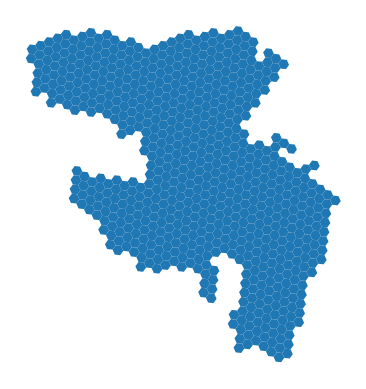

In [72]:
quito = up.download.nominatim_osm(
    "Distrito Metropolitano de Quito, Pichincha, Ecuador", email="your.email@example.com"
)

hexes = up.geom.gen_hexagons(resolution=7, city=quito) # Resolution 7: ~5km² hexagons

hexes.plot()
# remove axis
plt.axis('off')

plt.show()


# 2. Download Satellite Embeddings

Satellite embeddings are 64-dimensional learned representations that capture
land surface characteristics from multi-sensor satellite data.

For each hexagon, we download the embeddings from Google Earth Engine, reducing all embeddings in the hexagon to a single vector.

### Authenticate with Earth Engine

In [ ]:
# Initialize gee
import ee

# Authenticate with Earth Engine
ee.Initialize(project='your-project-id')


### Download and validate embeddings

In [76]:
embeddings = up.download.google_satellite_embeddings(
        hexes, 
        year=2023
)

embedding_cols = [col for col in embeddings.columns if col.startswith('A')]
valid_hexes = embeddings[embedding_cols[0]].notna().sum()

print(f"Successfully downloaded embeddings for {valid_hexes}/{len(embeddings)} hexagons")

if valid_hexes == 0:
    raise ValueError("No embedding data retrieved. Check Earth Engine authentication and project ID.")

embeddings.head()

Year: 2023, Bands: 64, Reducer: mean
Successfully downloaded embeddings for 718/718 hexagons


,hex,geometry,A00,A01,A02,A03,A04,A05,A06,A07,...,A54,A55,A56,A57,A58,A59,A60,A61,A62,A63
0,8766d3b94ffffff,"POLYGON ((-78.41946 0.2536, -78.42738 0.24282,...",-0.012210,-0.015765,0.047626,-0.047708,0.082852,-0.043358,0.006647,-0.016171,...,0.107443,-0.167098,0.026739,-0.076119,-0.204360,-0.079301,-0.001414,0.121799,-0.155974,-0.290017
1,8766d336bffffff,"POLYGON ((-78.19861 -0.20457, -78.20653 -0.215...",-0.028306,-0.012854,-0.031651,-0.112338,-0.109440,0.055266,0.055814,-0.179529,...,0.117777,-0.186690,0.041453,-0.031675,-0.179936,-0.216983,0.002417,0.207639,-0.183270,-0.190025
2,8766d3aa2ffffff,"POLYGON ((-78.37139 0.1195, -78.37931 0.10871,...",0.018828,0.027991,0.033058,-0.072527,0.065566,0.002892,0.091134,-0.072631,...,0.187224,-0.117045,0.055868,-0.039156,-0.217623,-0.099242,-0.020531,0.106371,-0.105937,-0.246816
3,8766d32f2ffffff,"POLYGON ((-78.48232 -0.37154, -78.49026 -0.382...",0.028986,-0.041577,0.026822,-0.067836,0.079977,0.027906,0.064005,-0.072225,...,0.207731,-0.131100,0.047927,-0.056856,-0.226265,-0.131128,0.095357,0.063385,-0.095334,-0.256757
4,8766d3200ffffff,"POLYGON ((-78.40857 -0.25094, -78.4165 -0.2617...",-0.000334,-0.016856,-0.024078,-0.059458,0.077509,0.027788,-0.022550,-0.039070,...,0.119422,-0.136492,0.044548,-0.090333,-0.212236,-0.154284,0.045116,0.071539,-0.110006,-0.327388


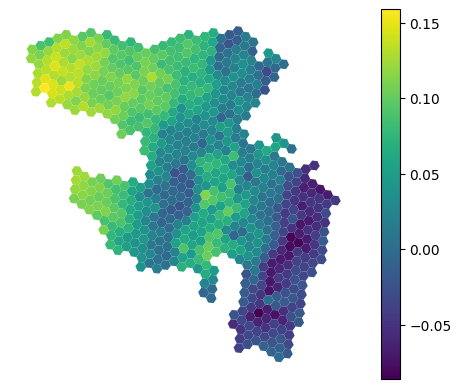

In [77]:

# Plot single band for visualization
embeddings.plot(column='A00', cmap='viridis', legend=True) 
plt.axis('off')
plt.show()

# 3. Analysis
Satellite embeddings can be used for a variety of tasks, such as classification, similarity search, and regression.

## 3.1 Clustering


In [83]:
K_CLUSTERS = 4 # Number of clusters
RANDOM_STATE = 33 # Random state for reproducibility
# Clean And Preprocess
band_cols = [f"A{str(i).zfill(2)}" for i in range(64)]

embeddings = embeddings.dropna(subset=band_cols).reset_index(drop=True)

X = embeddings[band_cols].to_numpy(dtype=float)

scaler = StandardScaler()
Xz = scaler.fit_transform(X)

km = KMeans(n_clusters=K_CLUSTERS, n_init="auto", random_state=RANDOM_STATE)
labels = km.fit_predict(Xz)

embeddings["cluster"] = labels.astype(int)


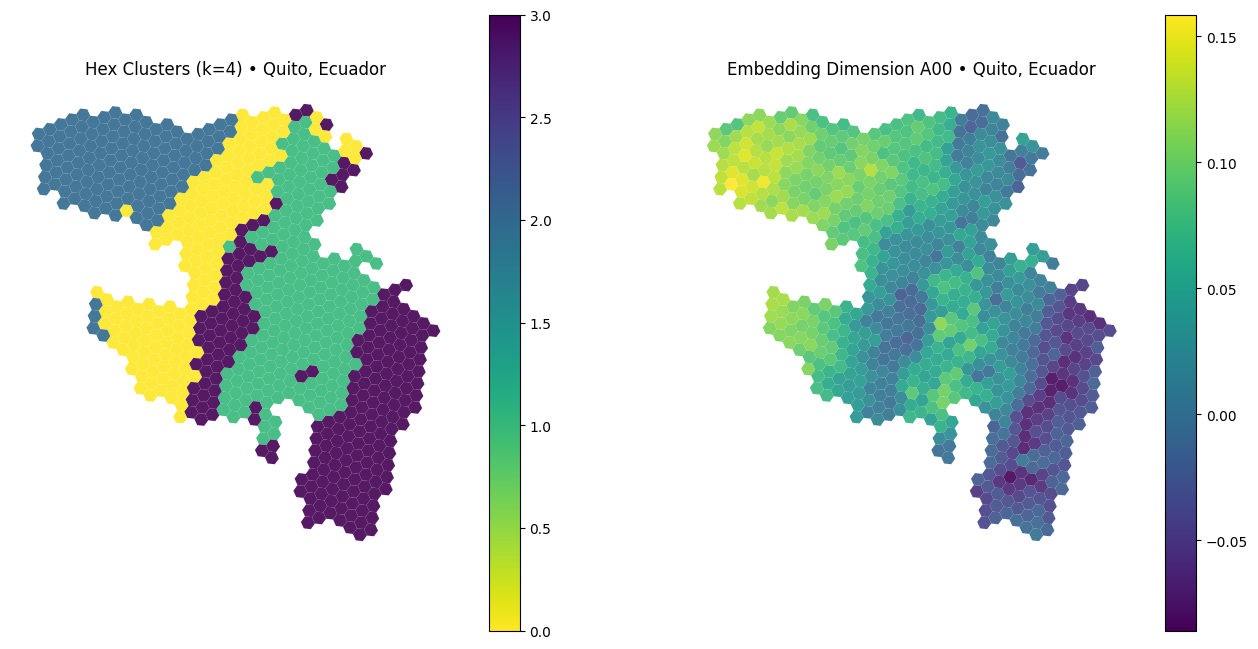

In [89]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

embeddings.plot(
    column="cluster",
    legend=True,
    alpha=0.9,
    linewidth=0.0,
    cmap='viridis_r',
    ax=ax1
)
ax1.set_title(f"Hex Clusters (k={K_CLUSTERS}) • Quito, Ecuador")
ax1.set_axis_off()

embeddings.plot(
    column="A00",
    cmap='viridis',
    legend=True,
    alpha=0.9,
    linewidth=0.0,
    ax=ax2
)
ax2.set_title(f"Embedding Dimension A00 • Quito, Ecuador")
ax2.set_axis_off()

plt.show()


## 3.2 Similarity Search

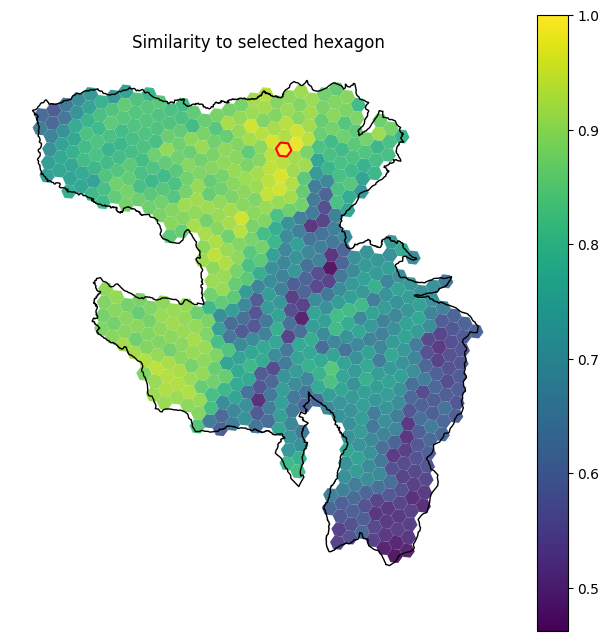

In [ ]:


# Pick a hexagon to compare against
hex_idx = 90 # 
v = gdf.iloc[hex_idx][embedding_cols].to_numpy(dtype=float).reshape(1, -1)

# Compute cosine similarity to all hexes
X = gdf[embedding_cols].to_numpy(dtype=float)
sims = cosine_similarity(X, v).ravel()

# Attach to GeoDataFrame
gdf["similarity"] = sims

# Plot, color map like heatmap
fig, ax = plt.subplots(figsize=(8, 8))
gdf.plot(column="similarity", legend=True, alpha=0.9, linewidth=0.0, ax=ax)
gpd.GeoDataFrame(geometry=quito.geometry).boundary.plot(ax=ax, color="black", linewidth=1.0)

# outline the selected hex
gdf.iloc[[hex_idx]].boundary.plot(ax=ax, color="red", linewidth=1.5)

ax.set_title("Similarity to selected hexagon")
ax.set_axis_off()
plt.show()
